In [1]:
# import necessary module
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import scipy
from array_response import *
import itertools 

In [2]:
Nt = 64 # number of transmit antennas
Nr = 16 # number of receive antennas
Ns = 1 # number of streams

Nc = 1 # number of cluster
Nray = 1 # number of rays in each cluster
realization = 10000 # equivalent to number of taking sample

At = np.zeros((Nt,Nc*Nray,realization),dtype=complex)
Ar = np.zeros((Nr,Nc*Nray,realization),dtype=complex)
alpha_hh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_hv = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vv = np.zeros((Nc*Nray,realization),dtype=complex)
var_hh = np.zeros((Nc*Nray,realization),dtype=float)

AoD = np.zeros((2,Nc*Nray),dtype=complex)
AoA = np.zeros((2,Nc*Nray),dtype=complex)

angle_sigma = 10/180*np.pi # standard deviation of the angles in azimuth and elevation both of Rx and Tx

gamma = np.sqrt((Nt*Nr)/(Nc*Nray))
count = 0

eps = 0.1 # 20dB isolation
sigma = np.sqrt(8/(1+eps**2)) # according to the normalization condition of H

for reali in range(realization):
    for c in range(1,Nc+1):
        AoD_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Departure _ azimuth
        AoD_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Departure _ elevation
        AoA_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Arrival_ azimuth
        AoA_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Arrival_ elevation
        AoD[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_azi_m, angle_sigma, (1,Nray))
        AoD[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_ele_m, angle_sigma, (1,Nray))
        AoA[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_azi_m, angle_sigma, (1,Nray))
        AoA[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_ele_m, angle_sigma, (1,Nray))
    for j in range(Nc*Nray):
        At[:,j,reali] = array_response(AoD[0,j],AoD[1,j],Nt) # UPA array response
        Ar[:,j,reali] = array_response(AoA[0,j],AoA[1,j],Nr)
        var_hh = ((sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_hv = ((eps**2)*(sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_vh = ((eps**2)*(sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[1,j])**2)).real
        var_vv = ((sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[1,j])**2)).real
        alpha_hh[j,reali] = np.random.normal(0, np.sqrt(var_hh/2)) + 1j*np.random.normal(0, np.sqrt(var_hh/2))
        alpha_hv[j,reali] = np.random.normal(0, np.sqrt(var_hv/2)) + 1j*np.random.normal(0, np.sqrt(var_hv/2))
        alpha_vh[j,reali] = np.random.normal(0, np.sqrt(var_vh/2)) + 1j*np.random.normal(0, np.sqrt(var_vh/2))
        alpha_vv[j,reali] = np.random.normal(0, np.sqrt(var_vv/2)) + 1j*np.random.normal(0, np.sqrt(var_vv/2))

In [3]:
azi_rot = np.random.uniform(0,2*np.pi,realization)
ele_rot = np.random.uniform(0,np.pi/2,realization) # Why PI/2 ??
ht_hr = np.zeros(realization,dtype=complex)
vt_hr = np.zeros(realization,dtype=complex)
ht_vr = np.zeros(realization,dtype=complex)
vt_vr = np.zeros(realization,dtype=complex)
same_cluster = np.zeros(realization,dtype=complex)
cross_polar = np.zeros(realization,dtype=complex)
same_polar = np.zeros(realization,dtype=complex)

for reali in range(realization):
    ht_hr[reali] = np.cos(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hh[0,reali]+np.sin(ele_rot[reali])*alpha_vh[0,reali]
    vt_hr[reali] = np.cos(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hv[0,reali]+np.sin(ele_rot[reali])*alpha_vv[0,reali]
    ht_vr[reali] = -np.sin(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hh[0,reali]+np.cos(ele_rot[reali])*alpha_vh[0,reali]
    vt_vr[reali] = -np.sin(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hv[0,reali]+np.cos(ele_rot[reali])*alpha_vv[0,reali]
    same_cluster[reali] = ht_hr[reali]+vt_hr[reali]+ht_vr[reali]+vt_vr[reali]
    cross_polar[reali] = vt_hr[reali]+ht_vr[reali]
    same_polar[reali] = ht_hr[reali]+vt_vr[reali]

2.14671980594
0.101797118149


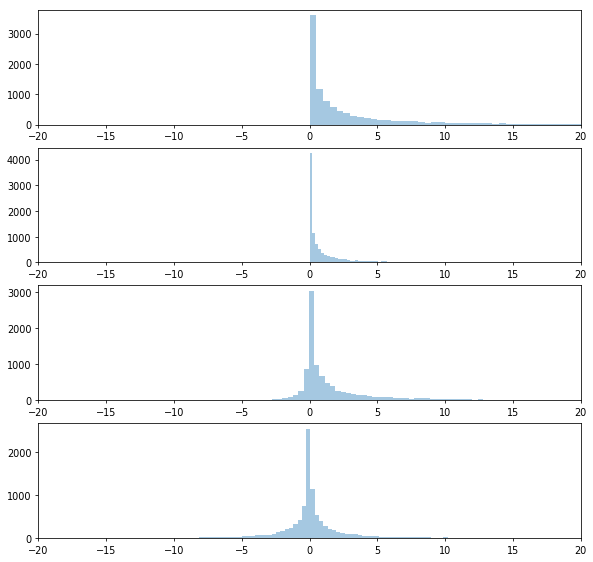

In [12]:
fig = plt.figure(figsize=(10,10), dpi=70)
# ax1 = fig.add_subplot(611)
# ax2 = fig.add_subplot(612)
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

ax1.set_xlim(-20,20)
ax2.set_xlim(-20,20)
ax3.set_xlim(-20,20)
ax4.set_xlim(-20,20)
# sns.distplot(np.abs(alpha_hh).reshape(1,-1),kde=False, ax=ax1)
# sns.distplot(np.angle(alpha_hh).reshape(1,-1),bins=100, kde = False, ax=ax2)
# sns.distplot(np.abs(ht_hr),bins=100, kde = False, ax=ax2)
# sns.distplot(np.angle(ht_hr),bins=100, kde = False, ax=ax4)

sns.distplot(np.abs(same_cluster)**2,bins=200, kde = False, ax=ax1)
sns.distplot(np.abs(cross_polar)**2,bins=200, kde = False, ax=ax2)
sns.distplot(np.abs(same_cluster)**2 - np.abs(cross_polar)**2,bins=300, kde = False, ax=ax3)
sns.distplot(np.abs(same_polar)**2 - np.abs(cross_polar)**2,bins=300, kde = False, ax=ax4, )

print(np.mean(np.abs(same_cluster)**2 - np.abs(cross_polar)**2))
print(np.mean(np.abs(same_polar)**2 - np.abs(cross_polar)**2))